In [569]:
from cpymad.madx import Madx
import matplotlib.pyplot as plt
import numpy as np
# my plotting style, please use your own!
plt.style.use('~/Documents/code/stylelib/madx.mplstyle')

In [570]:
# initiate madx
madx = Madx()



  +     MAD-X 5.09.03  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2024.04.25               +
  + Execution date: 2024.07.01 16:21:42      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [571]:
madx.command.title('R3 Ring with 124Xe Beam')

True

In [572]:
# parameters
amu_mev = 931.49410242 # MeV
beam_energy = 200.0 # MeV/u
circumference = 60.35075196 # from madx, not geometrical
n_turns = 1 # full turns of the ring

In [573]:
# input n_turns for sequence file
madx.input(f'n_turns = {n_turns};')
# call sequence
madx.call(file='r3_center.seq')

! r3 ring sequence with refer = center for use of makethin command etc.

! G.Hudson-Chang June 2024



! ===== parameters =====

full_gap = 0.08; ! Full width pole to pole gap [m]

b_angle = 15*raddeg; ! Bending angle [rad.]

b_rad_tarnd = 4.045; ! Bending radius of TARNII-D [m]



! ===== lengths =====

l_dp = b_rad_tarnd*b_angle; ! length of dipole

l_dp_drft = 0.6; ! drift section between R3 dipoles



l_str = 4.022544566; ! straight section

l_str_hf = 2.011272283; ! half straight section



l_r3_bend = 4*l_dp+3*l_dp_drft; ! length of r3_bend section

l_r3_bend_hf = l_r3_bend/2; ! length of r3_bend section

l_ring = 6*l_r3_bend+6*l_str;



! ===== dipole magnets =====

! ring dipole with trim coil

dp_trim: sbend, 

        l = l_dp,

        angle = b_angle,

        hgap = full_gap/2,

        ! tilt = 0.0*raddeg,

        e1 = 7.5*pi/180,

        e2 = 7.5*pi/180,

        fint = 0.654, ! fint is same as old tarnii-file

        k1 = 0.0739951, ! tilted magnetic field (first ord

In [574]:
# initiate beam with initial conditions
madx.command.beam(
    mass = 66*amu_mev/1000, # input is GeV
    charge = 30.0,
    energy = 128*(amu_mev+beam_energy)/1000, # also GeV
    sigt = 4.4616, # bunch length
    sige = 0.001, # rel energy spread
    kbunch = 18, # n bunches in machine
    radiate = True, # synchrotron radiation
    bunched = True,
)

True

In [575]:
# use the beam in the sequence
madx.use(sequence = 'full_ring')

In [576]:
# matching copied from old ring file by Y. Yamaguchi
madx.command.match(sequence = 'full_ring')
madx.command.constraint(mux = 1.216)
madx.command.vary(NAME = 'dp_trim->k2', step = 0.001, lower = -1.0, upper = 1.0)
madx.command.simplex(calls = 100000, tolerance = 1.0e-12)

START MATCHING

number of sequences: 1
sequence name: full_ring
++++++ warning: TWCPGO:  TWISS uses the RF system or synchrotron radiation only to find the closed orbit, for optical calculations it ignores both.
number of variables:    1
user given constraints: 1
total constraints:      74

START SIMPLEX:

++++++ warning: TWCPGO:  TWISS uses the RF system or synchrotron radiation only to find the closed orbit, for optical calculations it ignores both.
++++++ warning: TWCPGO:  TWISS uses the RF system or synchrotron radiation only to find the closed orbit, for optical calculations it ignores both.
++++++ warning: TWCPGO:  TWISS uses the RF system or synchrotron radiation only to find the closed orbit, for optical calculations it ignores both.
++++++ warning: TWCPGO:  TWISS uses the RF system or synchrotron radiation only to find the closed orbit, for optical calculations it ignores both.
++++++ warning: TWCPGO:  TWISS uses the RF system or synchrotron radiation only to find the closed o

True

In [577]:
madx.command.endmatch()

++++++ warning: TWCPGO:  TWISS uses the RF system or synchrotron radiation only to find the closed orbit, for optical calculations it ignores both.

MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------
++++++ warning: TWCPGO:  TWISS uses the RF system or synchrotron radiation only to find the closed orbit, for optical calculations it ignores both.
full_ring$start:1          mux          4     1.21600000E+00     0.00000000E+00     1.47865600E+02
r3_bend$start:1            mux          4     1.21600000E+00     0.00000000E+00     1.47865600E+02
bm1:1                      mux          4     1.21600000E+00     2.02904886E-02     1.42972124E+02
drift_0:0                  mux          4     1.21600000E+00     3.22456791E-02     1.40127429E+02
bm2:1                      mux          4     1.21600000E+00     5.38035681E-02     1.35070055E+02
dr

True

In [578]:
madx.use(sequence='full_ring')

In [579]:
twiss = madx.twiss(deltap = '-0.005,0.0,0.005')

enter Twiss module
  
iteration:   1 error:   3.614693E-02 deltap:  -5.000000E-03
orbit:  -3.316949E-02 -6.122167E-06  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   2 error:   7.061123E-05 deltap:  -5.000000E-03
orbit:  -3.318997E-02 -1.779256E-08  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   3 error:   1.624422E-09 deltap:  -5.000000E-03
orbit:  -3.318997E-02 -1.778213E-08  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
++++++ warning: TWCPGO:  TWISS uses the RF system or synchrotron radiation only to find the closed orbit, for optical calculations it ignores both.

++++++ table: summ

            length             orbit5               alfa            gammatr 
       60.35075196                 -0       0.6697053866        1.221963135 

                q1                dq1            betxmax              dxmax 
       1.221731709      -0.1856375079        8.066193926        7.302287883 

             dxrms             xcomax

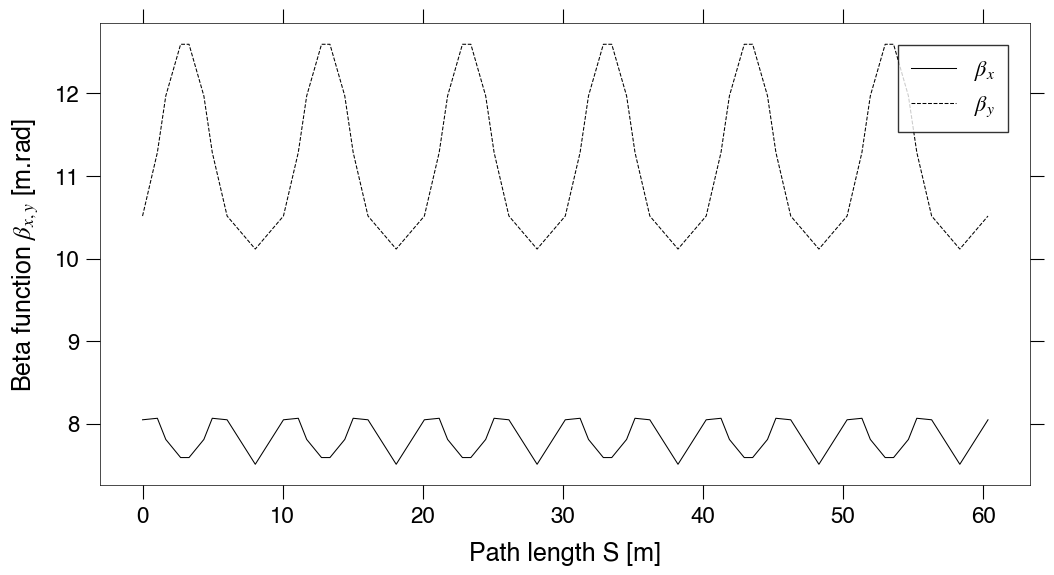

In [580]:
# low res. initial beta function plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(twiss['s'], twiss['betx'], label=r'$\beta_x$', color='black')
ax.plot(twiss['s'], twiss['bety'], label=r'$\beta_y$', color='black', linestyle='--')

ax.set_xlabel('Path length S [m]')
ax.set_ylabel(r'Beta function $\beta_{x,y}$ [m.rad]')

ax.legend();

In [581]:
# invoke ptc tracking module
madx.command.ptc_create_universe()

Determined SECTOR NMUL MAX :  3


True

In [582]:
# create layout
madx.command.ptc_create_layout(
    model = 2, # matrix-kick-matrix model
    method = 6, # integration order
    nst = 10, # no. of integration steps for each element
    # exact = True, # flag to switch on exact hamiltonian
)
# additional options
madx.command.ptc_setswitch(
    fringe = True, # fringe field effects
    radiation = True, # synchrotron radiation
    # time = True,
    # totalpath=True,
    debuglevel = 2,
)
# initialise particle
madx.command.ptc_start(x=0.08, pt=0.01)

# add observation point
madx.command.ptc_observe(place = 'bpm_schottky')

# number of turns
n_turns = 2000

 MAD-X Beam Parameters
                  Energy : 0.144831E+03
          Kinetic Energy : 0.833526E+02
      Particle Rest Mass : 0.614786E+02
                Momentum : 0.131135E+03
 Cannot do spin : provide a=g-2. Now it is set to zero.
 Setting MADx with 
     energy           144.83124510976000     
     method                   6
     Num. of steps           10
     charge           1.0000000000000000     
  Length of machine:    60.350751963541470     
 The machine is a RING
 ------------------------------------ PTC Survey ------------------------------------
 Before start:    0.0000000000000000        0.0000000000000000        0.0000000000000000     
 Before   end:    0.0000000000000000        0.0000000000000000        0.0000000000000000     
 After  start:    0.0000000000000000        0.0000000000000000        0.0000000000000000     
 After    end:    3.5122108657538453E-014   0.0000000000000000       -1.2434497875801753E-014
 Setting debug level to           2
maxaccel is not 

In [583]:
madx.command.ptc_track(
        closed_orbit = True,
        element_by_element = True,
        turns = n_turns,
        deltap = 3e9,
        maxaper = [0.24, 0.03, 0.05, 0.01, 1.0, 0.1], # maximum aperture
        file = 'data/r3_track_ipynb',
        extension = '.out'
)

track_deltap:         3000000000
 ************ State Summary ****************
 MADTHICK=>KIND =   37  MATRIX-KICK-MATRIX     
  Rectangular Bend: input arc length (rho alpha) 
  Default integration method     6
  Default integration steps     10
 This a particle with    120310.64008981     times the electron mass 
       EXACT_MODEL =  FALSE
       TOTALPATH   =     0
       RADIATION   =  TRUE 
       STOCHASTIC  =  FALSE
       ENVELOPE    =  FALSE
       NOCAVITY    =  TRUE 
       TIME        =  TRUE 
       FRINGE      =  TRUE 
       PARA_IN     =  FALSE
       ONLY_2D     =  FALSE
       ONLY_4D     =  TRUE 
       DELTA       =  FALSE
       SPIN        =  FALSE
       MODULATION  =  FALSE
       RAMPING     =  FALSE
       ACCELERATE  =  FALSE
  Radiation_PTC    =      F
 ************ State Summary ****************
 MADTHICK=>KIND =   37  MATRIX-KICK-MATRIX     
  Rectangular Bend: input arc length (rho alpha) 
  Default integration method     6
  Default integration steps    

True

In [584]:
# import data from bpm in the centre of the schottky straight section
p001 = np.transpose(np.genfromtxt('data/r3_track_ipynb.obs0002.p0001.out', skip_header=8))

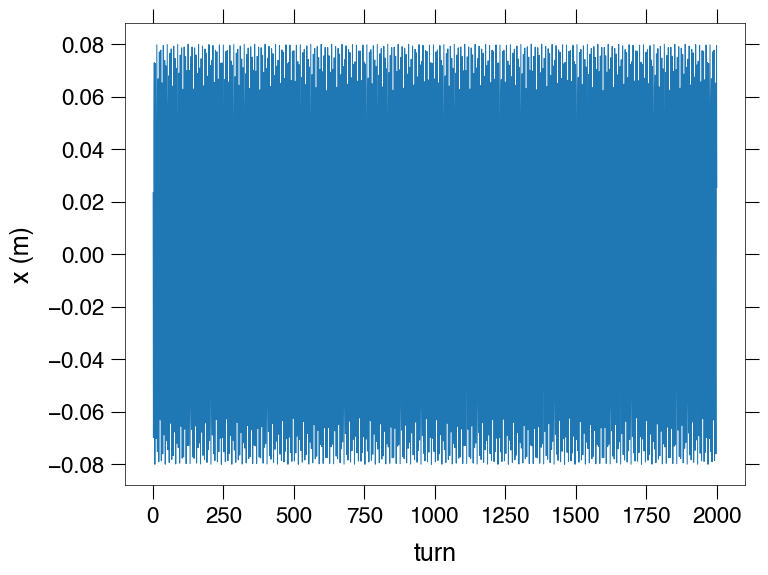

In [585]:
# x vs turns for bpm in the centre of the schottky straight section
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(p001[1], p001[2])
# ax.plot(p002[1], p002[2])

ax.set_xlabel('turn')
ax.set_ylabel('x (m)')
plt.show()

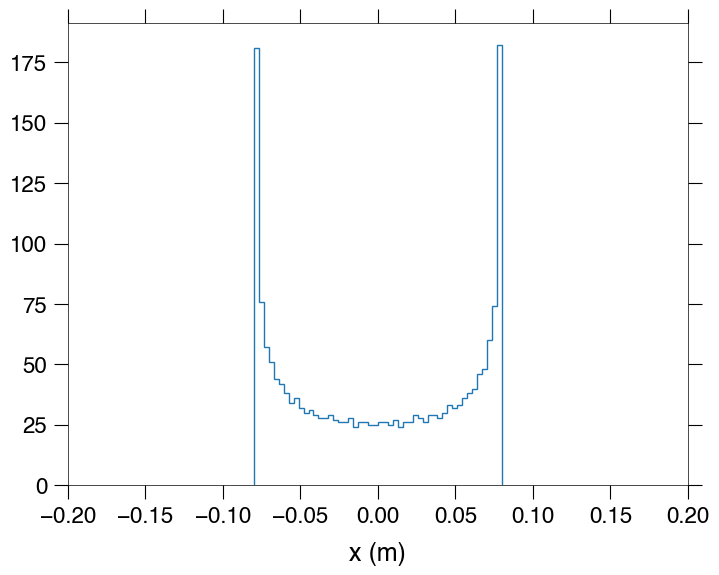

In [586]:
# x axis distribution at the position schottky bpm
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(p001[2],
        bins=50,
        histtype='step',
        )

ax.set_xlabel('x (m)')
ax.set_xlim([-0.2,0.2])

plt.show()